# Speech Processing - Instituto Superior Técnico
### Laboratory Assignment 2 - Spoken Language Indentification challenge

The second laboratory assignment of the course is designed to simulate a **spoken language identification** challenge. In this challenge, partipants (a.k.a students enrolled in the course) receive a train, development and evaluation (blind) data set, and a simple (and weak) baseline system for the task at hand: closed-set identification of the spoken language in a given audio file out of a set of six target langauges: Basque,  Catalan,  English,  Galician,  Portuguese and  Spanish.

The **goal** for each participant is to develop/build the best spoken language identification system. To this end, participants are encouraged to modify this baseline, incorporate any other techniques and in general explore any approach that permit  improving their results.

During the first week (Part 1), students are expected to:
- Run and understand the main components of the baseline.
- Propose and develop simple modifications to the baseline feature extraction process.
- Propose and develop simple modifications to the baseline GMM language models.
- Evaluate the models on the development partition.

During the second week (Part 2), students are expected to:
- Propose and develop other *classical* modifications to any component of the processing pipeline (openSMILE features, segment-based features, SVM classifiers, MLP/CNN classifiers, etc.)
- Run and understand the second part of Notebook that explores a pre-trained model.
- Propose and develop more recent advanced approaches, including x-vectors.
- Evaluate the models on the development partition.
- Obtain predictions for the blind test partition and prepare the submission.

The challenge distinguishes two different tracks or evaluation conditions:
- Track 1 - Participants are not allowed to use any kind of pre-trained model (such as x-vectors).
- Track 2 - Participants are allowed to use anything.


## About the data

The data consists of mono audio files sampled at 16 kHz all of them containing speech of only one of the following target languages:
```python 
LANGUAGES = ('Basque',  'Catalan',  'English',  'Galician',  'Portuguese',  'Spanish')
```

The dataset is organized in 4 partitions:
- `'train'`: This is the full training set, consisting of 3060 clean audio samples correponding to speech segments of TV broadcast shows. (**ATENTION**: Do not use this dataset for training your models, unless your system is very fast or if you want to build your final model. It can be slow)
- `'train100'`: This is a subset of the full training set that consists of 100 audio files per target language (**RECOMMENDATION**: Use this partition in your quick experiments, to more rapidly validate alternatives)
- `'dev'`: This is the development set. It contains audio extracted from YouTube. You will typically use this to validate the quality of your model.
- `'evl'`: This is the evaluation set. It contains audio extracted from YouTube. You don't have the groud-truth for this set. You are expected to produce it and submit it.

The data used in this challenge is a subset of the KALAKA-3 database: https://aclanthology.org/L14-1576/

The  difference is that only the clean train audio segments and the Plenty Closed evaluation condition have been considered. 

## Before starting
The following conditions are neecessary to run correctly this notebook:

*   All modules included in the requirements file need to be 
installed in the Python environment.
*   The module `pf_tools` needs to be accessible (if you are using Google Colab, you will need to copy the `pf_tools.py` every time you start a new session).

In [10]:
from pf_tools import CheckThisCell

## How can you download (and process) the data

The first thing we have to do is to set our working directory. If you are using Google Colab, you  probably want to mount Google Drive to keep persistent information, such as data, features and models:

In [11]:
#raise CheckThisCell ## <---- Remove this after completeing/checking this cell
import os 
CWD = os.getcwd() + '' # Change this variable to your working directory to store data, features and models
CWD

'C:\\Users\\ritas\\OneDrive - Universidade de Lisboa\\Ambiente de Trabalho\\MECD\\Processamento Fala\\Lab2'

The class `Kalaka` permits downloading, transforming and storing the different data partitions. Each `Kalaka` instance can be used to iterate over all the samples of the partition. It can also be used in combination with pytorch dataloader to read batches of data to train neural networks with pytorch. For instance, consider the following piece of code:


In [103]:
import numpy as np
from pf_tools import Kalaka
import librosa 

def audio_transform(filename):
    y, _ = librosa.load(filename, sr=16000, mono=True)
    return y.reshape(-1,1)
    
trainkalaka = Kalaka(CWD, 'train100', transform_id='raw', audio_transform=audio_transform)

100%|██████████| 600/600 [00:42<00:00, 13.99it/s]



This will first download and uncompress the .tar.gz file containing all the necessary data of the `'train100'` partition, that is, the audio files that are stored to disk (in CWD/train100/audio/) and key file (CWD/train100/key.lst). Then, the audio transformation `'transform'` will be applied to each file and the result stored to disk CWD/train100/raw/. 

**Audio transformations** receive a filename of an audio file and returns an array of dimensions (NxD), in which N is the time dimension and D the dimension of the feature vector. In this simple case D is 1 because the transform is just returning the raw audio signal.

The `Kalaka` class permits chunking the output of the audio transformation (of size NxD) in chunks of CxD size. The chunking operation divides the orignal sample, in multiple smaller samples with a configurable chunk size and hop length. These chunks can be further transformed and stored as individual feature files. For instance:

In [6]:
trainkalaka = Kalaka(CWD, 'train100', 
                     transform_id='chunks', 
                     audio_transform=audio_transform, 
                     chunk_size=4*16000, 
                     chunk_hop=2*16000)

100%|██████████| 600/600 [01:13<00:00,  8.15it/s]


This will download and uncompress the partition data, only if was not already done before. Then, as previously, the simple tranform that returns the waveform is applied to each audio file. After this, the resulting array of dimension Nx1, in which N=16000xduration_in_seconds, is split in continuous chunks of length 64000 (that is, 4 seconds) with chunk hop of 2 seconds. Each one of these chunks of 4 seconds is stored and will be accessed whenever we iterate the dataset. 

Adittionally, the optional argument `chunk_transform` pertmits defining a transformation to be applied to each chunk before storing to disk. It can be any function that receives an array of size CxD and returns an array HxW, in which H is the *new time dimension*. For instance, the following example takes the audio segments of 64000x1, computes the mean and variance every 0.1 sec (1600 samples) and returns a feature vector of size 40x2.

In [7]:
def chunk_transform(x):
    x = x.reshape(-1,1600)
    return np.concatenate((x.mean(axis=1, keepdims=True), x.std(axis=1, keepdims=True)),axis=1)

trainkalaka = Kalaka(CWD, 'train100', 
                     transform_id='chunks_mv', 
                     audio_transform=audio_transform, 
                     chunk_size=4*16000, 
                     chunk_hop=2*16000, 
                     chunk_transform=chunk_transform)


100%|██████████| 600/600 [00:19<00:00, 30.78it/s]



Notice that, while the above example is probably useless as an effective feature extraction method, the proper combination of audio and chunk transformations is expected to permit quite flexible feature extraction that (hopefully) can match the needs of almost any training setting. 

Once we have instanciated a Kalaka dataset, it can be iterated to have access to each processed sample, for instance: 

In [8]:
import time
start = time.time()
for i, sample in enumerate(trainkalaka):
    data, label, basename = sample # array, int, str
    if i % 1000 == 0:
        print(i, data.shape, label, basename)

print(f'Finished reading all data in {time.time() - start}')

0 (40, 2) 6 0006ebda
1000 (40, 2) 1 11a3790f
2000 (40, 2) 4 271621da
3000 (40, 2) 5 3b9d2c2f
4000 (40, 2) 1 4d10f8f2
5000 (40, 2) 6 5fb949a1
6000 (40, 2) 6 70d28e30
7000 (40, 2) 6 7d5515f0
8000 (40, 2) 3 937623c2
9000 (40, 2) 5 a4a7491b
10000 (40, 2) 5 bc3f6e51
11000 (40, 2) 3 cd82bcca
12000 (40, 2) 1 df0b27f2
13000 (40, 2) 3 f3ba1f4d
Finished reading all data in 1.0377135276794434


Now you can use the `Kalaka` class to check the  number of files and size (in minutes) of the training set for each target language. You cankKeep these numbers to include in your system description paper:

Notice that the `Kalaka` class extends the `torch.utils.data.Dataset` and it can be used in combination with a Pytorch DataLoader to read data in batches:

In [9]:
import torch 

trainkalaka = Kalaka(CWD, 'train100', 
                     transform_id='chunks_mv', 
                     audio_transform=audio_transform, 
                     chunk_size=4*16000, 
                     chunk_hop=2*16000, 
                     chunk_transform=chunk_transform)

dataloader = torch.utils.data.DataLoader(
        dataset=trainkalaka,
        batch_size=10,
        shuffle=True
)

start = time.time()
for i, batch in enumerate(dataloader):
    data, label, basename = batch
    if i % 100 == 0:
        print(data.shape, label.shape, len(basename))

print(f'Finished reading all data in {time.time() - start}')


/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
Finished reading all data in 8.849694728851318


Finally, remind that you can change anything you want. This includes the Kalaka class. Eventually, you can decide not using it at all and loading the data in some alternative way.  You can inspect the class to find the URLs for downloading the datasets. It is up to you! 

Before moving to the next stage, you probably want to delete the folders containing the dummy features that you just generated.

# PART 1 - The baseline (Track 1)
The baseline consists of MFCC feature extraction  (based on the `librosa` module) with SDC computation and VAD removal, followed by GMMs of 64 dimensions for each language (using the `sklearn` module). The rest of this notebook contains the guide and code cells (some of them partially incomplete) that permit implementing this baseline and score it on the development set. Read carefully the Markdown information, but also the comments inside the code cells (they provide useful information and hints), and also the code itself. The better you understand it, the easier will be modyfing it.

## Initialization and importing modules

In [34]:
!pip install opensmile

  Created wheel for iso-639: filename=iso_639-0.4.5-py3-none-any.whl size=168855 sha256=46dfe81dbbdb7e8821dfab8b7659be7de7d15ffd8e496bde7bff3af3a6915dd2
  Stored in directory: c:\users\ritas\appdata\local\pip\cache\wheels\43\3f\de\07f35ac2a2cd11ff30224e3fc6fbf458d7fc95effb1f673431
Successfully built iso-639


In [1]:
import os
from pf_tools import Kalaka
import librosa
import numpy as np
import torch
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

import time
import random
import datetime
from pathlib import Path
import pickle
import csv 
from tqdm import tqdm
import opensmile #feature extraction
import importlib #reload packages

opensmile=importlib.reload(opensmile)

GLOBAL_SEED = 35731

np.random.seed(GLOBAL_SEED)
torch.manual_seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)


LANGUAGES = ('Basque',  'Catalan',  'English',  'Galician',  'Portuguese',  'Spanish')
LANG2ID = {'Basque':1, 'Catalan':2, 'English':3, 'Galician':4, 'Portuguese':5, 'Spanish':6}
ID2LANG = dict((LANG2ID[k],k) for k in LANG2ID)

## The baseline feature extraction module
The next function extracts MFCCs, but there are plenty of things that can be improved. You are free to change anything you want, including the number of formal parameters, the number of returned expressions, etc. 

In [104]:
# Read carefully this function and understand it

def feat_extract(filename, orig_sr=16000, mono=True, n_mfcc = 13, remove_c0=False, delta_order=0, 
                 apply_sdc=False, apply_vad=False, apply_cmvn=False, opensmile_Q=False):
    
    sr=16000
    n_mels = 40
    n_fft = 512 
    hop_length = 160
    fmin = 50
    fmax = 7800
    
    if apply_sdc and (delta_order > 0):
        raise ValueError("Applying SDC and delta > 0 is not compatible")
    if apply_cmvn and opensmile_Q:
        raise ValueError("Applying CMVN and opensmile is not compatible")
    
    # Load audio wav into numpy array
    y, _ = librosa.load(filename, sr=orig_sr, mono=mono)
    
    # Resample in case it's needed
    if orig_sr != sr:
        y = librosa.resample(y, orig_sr=orig_sr,target_sr=sr)
    
        
    ## OPTIONAL ADDIDITIONAL STAGES - LAB WORK
    # 1 - PREPROCESSING - Typical preprocessing may include normalization of audio (mean removal), 
    #                       but also speech enhancement and others more complex
    
    # Extract MFFCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft, 
                                n_mfcc=n_mfcc, n_mels=n_mels, 
                                hop_length=hop_length, 
                                fmin=fmin, fmax=fmax, htk=False).T
    
    ## OPTIONAL ADDIDITIONAL STAGES - LAB WORK

    # 2 Compute deltas --> Hint you can use librosa (order size may be a parameter?)
    if delta_order > 0:
        mfcc = compute_delta(mfcc,delta_order=delta_order)
    
    # 3 SDC --> Hint: You can build this using deltas (of extented context)  
    if apply_sdc:
        mfcc = compute_sdc(mfcc)
    
    # 4 COMPUTE VAD --> Hint: You can use any vad (theshold energy, something avaialble in the net, a biGaussian model...).
    #                         Coeff0 is highly related with Energy and sometimes it is removed
    #                   ATTENTION: Using a VAD may have a significant impact  
    if apply_vad:
        mfcc, _ = compute_vad(mfcc)
             
    # 5 APPLY CMVN --> ATTENTION: Using normalization may have a significant impact
    if apply_cmvn:
        mfcc = compute_cmvn(mfcc)

    return mfcc, y


Try to define some or all of the following steps to improve your feature extraction pipeline 

In [3]:
# Numpy arrays have methods to compute mean and variance, so this one should be really easy
# raise CheckThisCell ## <---- Remove this after completeing/checking this cell


def compute_cmvn(features):
    #return features/np.linalg.norm(features)
    return (features-np.mean(features))/np.std(features)

In [4]:
# librosa contains functions to compute deltas
# raise CheckThisCell ## <---- Remove this after completeing/checking this cell


def compute_delta(features, win=3, delta_order=2, keep_static=True):
    delta=librosa.feature.delta(features,width=win,order=delta_order)
    return np.hstack((features,delta))
    


In [5]:
# Compute deltas and then select previous and next deltas with fixed intervals to cocatentate. 
# You may need to code a bit here or dinf some function that helps with this
# raise CheckThisCell ## <---- Remove this after completeing/checking this cell


def compute_sdc(features, P=3, D=3, K=2, keep_static=True):
    delta=compute_delta(features,win=D,delta_order=1)[:,np.shape(features)[1]:]
    
    sdc=np.empty([np.shape(features)[0],np.shape(features)[1]*K])
    marker = np.zeros(features.shape[0], dtype='bool')
    for j in range(K):
        marker[D + j * P] = True
    for i in range(len(features)):
        sdc[i, :] = delta[marker, :].reshape(1, -1)
        marker = np.roll(marker, 1)
    return np.hstack((features,sdc))

In [6]:
# You can think of several strattegies to compute VAD, simple ones based on energy and a threshold, or maybe some more 
# ellaborated ones, like training a GMM with 2 mixtures with the Energy. 
# In addition to the features without some frames, this function may return a sequence of 0s and 1s that helps you to validate the method.
# raise CheckThisCell ## <---- Remove this after completeing/checking this cell

# Voice Activity Detection - Zero Crossing Rate
def zero_crossing_rate(x):
    return np.sum(np.abs(np.diff(np.sign(x)))/2)/len(x)

def compute_vad(features, energy=None, y=None):
    features_aux=features[:,0:int(np.shape(features)[1]/2)]
    zcr=np.empty(np.shape(features)[1])
    for i in range(len(zcr)):
        zcr[i]=zero_crossing_rate(features[:,i])
    GM=GaussianMixture(n_components=2)
    frame_class=GM.fit_predict(zcr.reshape(-1,1))
    vad=np.empty(np.shape(features))
    for i in range(len(zcr)):
        vad[:,i]=frame_class[i]
    return np.hstack((features,vad)),frame_class

You can test in an isolated audio file and inspect the dimensions, verify that your code is doing what is expected, inspect and visualize the data using some of the lessons learnt in LAB1. Also, don't forget to listen some of the examples!!

In [69]:
# raise CheckThisCell ## <---- Remove this after completeing/checking this cell

#mfcc, _=feat_extract(f'{CWD}/train100/audio/0006ebda.wav', apply_cmvn=True, apply_sdc=False,apply_vad=False)
#mfcc_dd, _ = feat_extract(f'{CWD}/train100/audio/0006ebda.wav', apply_cmvn=False, delta_order=2)
#mfcc_d, _ = feat_extract(f'{CWD}/train100/audio/0006ebda.wav', apply_cmvn=False, delta_order=1)
mfcc, y = feat_extract(f'{CWD}/train100/audio/0006ebda.wav', apply_cmvn=False)
open_smile_feats=feat_extract(f'{CWD}/train100/audio/0006ebda.wav', opensmile_Q=True)

In [70]:
np.shape(open_smile_feats)

(21114,)

To run the data processing stage for the train100 partition we will simply instanciate the Kalaka class as mentioned previosly. Take a sit because it can take a bit:

In [ ]:
#Transformation  Combinations attempted    BEST: mfcc_delta1
transform = { 'mfcc_sdc_vad_chunk_300_400' : 
                 { 
                     'audio_transform': lambda x : feat_extract(x, orig_sr=16000, mono=True, n_mfcc = 7, apply_sdc=False, apply_vad=False, apply_cmvn=True)[0],
                     'chunk_transform': None,
                     'chunk_size': 300,
                     'chunk_hop':300
                 },
                 'mfcc_delta1_vad' : 
                 { 
                     'audio_transform': lambda x : feat_extract(x, orig_sr=16000, mono=True,delta_order=1, n_mfcc = 13, apply_sdc=False, apply_vad=True, apply_cmvn=True)[0],
                     'chunk_transform': None,
                     'chunk_size': 300,
                     'chunk_hop':300
                 },
                 'mfcc_sdc' : 
                 { 
                     'audio_transform': lambda x : feat_extract(x, orig_sr=16000, mono=True,delta_order=0, n_mfcc = 13, apply_sdc=True, apply_vad=False, apply_cmvn=True)[0],
                     'chunk_transform': None,
                     'chunk_size': 300,
                     'chunk_hop':300
                 },
                 'mfcc_delta1' : 
                 { 
                     'audio_transform': lambda x : feat_extract(x, orig_sr=16000, mono=True,delta_order=1, n_mfcc = 13, apply_sdc=False, apply_vad=False, apply_cmvn=True)[0],
                     'chunk_transform': None,
                     'chunk_size': 300,
                     'chunk_hop':300
                 },
             'mfcc' : 
                 { 
                     'audio_transform': lambda x : feat_extract(x, orig_sr=16000, mono=True,delta_order=0, n_mfcc = 7, apply_sdc=False, apply_vad=False, apply_cmvn=False)[0],
                     'chunk_transform': None,
                     'chunk_size': 300,
                     'chunk_hop':300
                 },
            
            }


trainset = 'train100'
transform_id = 'mfcc'

trainkalaka = Kalaka(CWD, trainset, 
                 transform_id=transform_id, 
                 audio_transform=transform[transform_id]['audio_transform'], 
                 chunk_transform=transform[transform_id]['chunk_transform'],
                 chunk_size=transform[transform_id]['chunk_size'], 
                 chunk_hop=transform[transform_id]['chunk_hop']
                )

Check your current folder, many things happened!! 

Notice that if you instanciate again the Kalaka class for the 'train100' partition, the data will not be downloaded again. 
Additionally, if there is already a folder with the name `transform_id`, feature extraction will not run again. You need to delete from your filesystem the folder with the features if you want to run again the feature extraction (using the same identifier) or , alternatively, you can change the identifier. Be careful because you can easily increase the amount of data generated. If you try a feature extraction method that provides bad results, you probably don't want to keep the features in disk.

## The baseline spoken language models
The baseline model is extremely simple: we'll train an individual GMM model for each language on top of the features that we just extracted. Later, in prediction time, given a test audio sample, we'll compute the loglikelihood obtained with each GMM model and select as the identified language the one whose model gives the highest likelihood. Let's go for it!!


In [ ]:
# IN GMM training each training sample contains more than one frame;
# so we cocatenate all data to have all training datain one array 
# and the corresponding label with same time duration
# actually, here the chunking process is useless, I could have obtained the same without chunking (with slight differences due to trunkation)

#This method cannot be used with opensmile
start = time.time()
train_data = []
train_labels = []
for data, label, basename in trainkalaka:
        train_data.append(data)
        train_labels.append(np.full(data.shape[0], label)) 

train_data = np.concatenate(train_data)
train_labels = np.concatenate(train_labels)

print(f'Finished reading all data in {time.time() - start}')

Let's go training. Again, depending of the amount of data used, the model complexity and computational resources of the machine that you're using, this can take a while. So, relax while the computer works for you!

In [ ]:
## TRAIN GMM models (ML) 
models = {}
n_gauss = 64
for lang in LANGUAGES:
    models[lang] = GaussianMixture(n_components=n_gauss, covariance_type='diag', max_iter=20, n_init=1, init_params='kmeans', verbose=2, verbose_interval=1)
    
for lang in LANGUAGES:
    print(f'Training model for {lang}')
    models[lang].fit(train_data[train_labels==LANG2ID[lang]])


Now we have two arrays containing the complete training dataset and the corresponging reference labels. Check the sizes, may be have a look to the content of one time instant. Do some checks on the data to be sure that everything is as expected:

In [ ]:
# Check the traininig data. Notice that if you apply VAD, the size of the training data must be smaller than the complete data set. 
# Register the size in frames and in time of training data for each language
raise CheckThisCell ## <---- Remove this after completeing/checking this cell

# Creating Dataset from opensmile features

In [214]:
def opensmile_feats(signal,sr):
    smile = opensmile.Smile(
            feature_set=opensmile.FeatureSet.GeMAPSv01b ,
            feature_level=opensmile.FeatureLevel.Functionals,
        )
    opensmile_feats=smile.process_signal(signal,sr)
    return np.hstack(opensmile_feats.values)

In [146]:
#For opensmile:
train_data = []
train_labels = []
trainkalaka = Kalaka(CWD, 'train100', transform_id='raw', audio_transform=audio_transform)


start = time.time()
train_data = []
train_labels = []
i=0
for data, label, basename in trainkalaka:
    print(i)
    train_data.append(opensmile_feats(data.reshape(np.shape(data)[0]),sr=16000))
    train_labels.append([label]) 
    if i%100==0:
        print(i)
    i=i+1
        
#train_data = np.vstack(train_data)
#train_labels = np.concatenate(train_labels)

C:\Users\ritas\OneDrive - Universidade de Lisboa\Ambiente de Trabalho\MECD\Processamento Fala\Lab2\pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


0
                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:47.111000                          32.409214   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:47.111000                                  0.2279   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:47.111000                                   24.803448   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:47.111000                                   33.894669   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                      

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:51.305187                          29.384449   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:51.305187                                0.186078   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:51.305187                                   24.135225   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:51.305187                                   29.764549   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

Exception ignored on calling ctypes callback function: <function OpenSMILE.external_sink_set_callback_ex.<locals>.internal_callback_ex at 0x000001A0CAB4C310>
Traceback (most recent call last):
  File "C:\Users\ritas\anaconda3\lib\site-packages\opensmile\core\SMILEapi.py", line 362, in internal_callback_ex
    def internal_callback_ex(data, nt, n, meta: POINTER(FrameMetaData), _):
KeyboardInterrupt: 
C:\Users\ritas\anaconda3\lib\site-packages\opensmile\core\smile.py:307: UserWarning: Segment too short, filling with NaN.
  warnings.warn(


                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:52.298875                                NaN   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:52.298875                                     NaN   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:52.298875                                         NaN   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:52.298875                                         NaN   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:43.707250                          26.957767   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:43.707250                                 0.09186   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:43.707250                                   25.044266   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:43.707250                                   26.857534   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

Exception ignored on calling ctypes callback function: <function OpenSMILE.external_sink_set_callback_ex.<locals>.internal_callback_ex at 0x000001A0C8E46CA0>
Traceback (most recent call last):
  File "C:\Users\ritas\anaconda3\lib\site-packages\opensmile\core\SMILEapi.py", line 362, in internal_callback_ex
    def internal_callback_ex(data, nt, n, meta: POINTER(FrameMetaData), _):
KeyboardInterrupt: 
C:\Users\ritas\anaconda3\lib\site-packages\opensmile\core\smile.py:307: UserWarning: Segment too short, filling with NaN.
  warnings.warn(


                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:55.451812                                NaN   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:55.451812                                     NaN   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:55.451812                                         NaN   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:55.451812                                         NaN   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:01:11.070000                          20.970129   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:01:11.070000                                 0.14828   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:01:11.070000                                   18.396633   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:01:11.070000                                    20.66087   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:47.270000                          27.059473   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:47.270000                                0.135404   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:47.270000                                   25.008324   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:47.270000                                     27.2234   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:54.632812                          25.596119   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:54.632812                                0.158759   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:54.632812                                   22.666397   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:54.632812                                   24.381384   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:53.377500                          32.379837   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:53.377500                                0.145338   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:53.377500                                   28.123301   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:53.377500                                   33.871078   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:43.507937                          38.068089   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:43.507937                                0.149271   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:43.507937                                   35.134838   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:43.507937                                   38.835556   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

Exception ignored on calling ctypes callback function: <function OpenSMILE.external_sink_set_callback_ex.<locals>.internal_callback_ex at 0x000001A0C8E439D0>
Traceback (most recent call last):
  File "C:\Users\ritas\anaconda3\lib\site-packages\opensmile\core\SMILEapi.py", line 362, in internal_callback_ex
    def internal_callback_ex(data, nt, n, meta: POINTER(FrameMetaData), _):
KeyboardInterrupt: 
C:\Users\ritas\anaconda3\lib\site-packages\opensmile\core\smile.py:307: UserWarning: Segment too short, filling with NaN.
  warnings.warn(


                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:39.290000                                NaN   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:39.290000                                     NaN   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:39.290000                                         NaN   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:39.290000                                         NaN   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:47.895562                          27.745798   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:47.895562                                0.172911   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:47.895562                                   23.062803   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:47.895562                                   26.760603   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:46.927187                          28.324539   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:46.927187                                0.139239   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:46.927187                                    24.55163   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:46.927187                                   28.515167   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:48.049500                          27.449291   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:48.049500                                0.197284   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:48.049500                                   22.608545   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:48.049500                                   26.734968   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:44.981500                          28.519909   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:44.981500                                0.133394   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:44.981500                                   25.334131   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:44.981500                                   28.379799   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:01:01.642437                          27.542078   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:01:01.642437                                0.175414   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:01:01.642437                                    23.35844   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:01:01.642437                                   27.049309   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:01:01.773437                          29.014753   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:01:01.773437                                0.074069   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:01:01.773437                                   27.471649   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:01:01.773437                                   29.048197   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:49.370000                          32.190285   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:49.370000                                0.146584   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:49.370000                                   28.326948   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:49.370000                                   31.996279   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:52.580000                          26.213617   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:52.580000                                0.132567   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:52.580000                                   23.494633   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:52.580000                                   25.716589   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:01:04.819937                          26.660711   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:01:04.819937                                  0.1482   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:01:04.819937                                   23.669485   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:01:04.819937                                   26.612036   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:40.744250                          33.762676   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:40.744250                                 0.12265   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:40.744250                                   30.661179   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:40.744250                                    33.47683   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:46.458500                          26.364822   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:46.458500                                0.131017   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:46.458500                                   23.312023   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:46.458500                                   26.170774   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:44.422812                          34.101387   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:44.422812                                0.111122   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:44.422812                                   32.246216   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:44.422812                                   34.366314   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:51.460687                          30.482695   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:51.460687                                0.085174   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:51.460687                                   28.571182   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:51.460687                                   30.533077   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:39.796187                          33.174702   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:39.796187                                0.095465   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:39.796187                                   30.984037   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:39.796187                                   33.158085   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:50.481375                           34.24752   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:50.481375                                0.133981   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:50.481375                                   31.644302   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:50.481375                                   34.839947   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:44.682125                          31.476109   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:44.682125                                0.110071   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:44.682125                                   29.222183   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:44.682125                                   31.220282   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:43.334875                          25.737566   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:43.334875                                0.155092   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:43.334875                                   21.951914   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:43.334875                                   26.157209   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:46.506062                          29.947859   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:46.506062                                0.169183   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:46.506062                                   24.171209   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:46.506062                                    31.80518   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:41.869125                          33.660175   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:41.869125                                0.067672   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:41.869125                                   32.103077   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:41.869125                                   33.408352   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:47.790000                          25.321865   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:47.790000                                0.199141   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:47.790000                                    20.36759   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:47.790000                                   26.273949   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:59.690000                          34.942699   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:59.690000                                0.114166   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:59.690000                                   33.154377   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:59.690000                                   34.860653   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:47.726750                          35.984085   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:47.726750                                0.121768   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:47.726750                                   33.630138   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:47.726750                                   36.686237   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:47.207625                          35.966164   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:47.207625                                0.115959   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:47.207625                                   32.540939   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:47.207625                                   36.291527   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                                  F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                            
0 days 0 days 00:00:43.517561999                          25.184353   

                                  F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                                 
0 days 0 days 00:00:43.517561999                                0.235429   

                                  F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                     
0 days 0 days 00:00:43.517561999                                    21.44059   

                                  F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                     
0 days 0 days 00:00:43.517561999                                   24.080864   

                                  F0semitoneFrom27.5Hz_sma3nz_percentile80.

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:55.950000                          32.442696   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:55.950000                                0.223942   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:55.950000                                   25.282907   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:55.950000                                   33.540386   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:43.836375                          27.163855   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:43.836375                                0.133633   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:43.836375                                   24.627859   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:43.836375                                   26.679794   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:37.310000                          27.671928   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:37.310000                                0.123373   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:37.310000                                   24.990347   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:37.310000                                   27.806568   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:47.959875                          37.362778   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:47.959875                                0.095451   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:47.959875                                   34.951981   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:47.959875                                    37.42767   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:42.320562                          29.655762   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:42.320562                                0.147067   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:42.320562                                   26.421141   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:42.320562                                   29.259445   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:49.492312                           27.57826   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:49.492312                                0.131938   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:49.492312                                   24.434456   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:49.492312                                   28.199665   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:50.430937                          32.261551   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:50.430937                                 0.10081   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:50.430937                                   29.655085   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:50.430937                                   32.104694   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:50.805937                           34.91589   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:50.805937                                0.143934   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:50.805937                                   31.157465   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:50.805937                                   34.369953   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:42.801312                          28.054995   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:42.801312                                 0.16514   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:42.801312                                    24.62771   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:42.801312                                   26.952301   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:43.729750                           35.61631   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:43.729750                                0.171179   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:43.729750                                   33.540585   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:43.729750                                   36.200691   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                                  F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                            
0 days 0 days 00:00:44.535186999                          29.363758   

                                  F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                                 
0 days 0 days 00:00:44.535186999                                0.149262   

                                  F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                     
0 days 0 days 00:00:44.535186999                                   26.241302   

                                  F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                     
0 days 0 days 00:00:44.535186999                                   28.125244   

                                  F0semitoneFrom27.5Hz_sma3nz_percentile80.

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:51.727812                          34.832207   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:51.727812                                0.097254   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:51.727812                                   32.260578   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:51.727812                                   34.736916   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:41.022937                          24.820786   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:41.022937                                0.191061   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:41.022937                                   21.553907   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:41.022937                                   24.420731   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:55.650875                          36.485027   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:55.650875                                0.115747   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:55.650875                                   33.218964   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:55.650875                                   36.779408   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:37.930000                          32.878254   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:37.930000                                0.184518   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:37.930000                                   25.656551   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:37.930000                                   34.767639   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:53.474312                          26.077631   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:53.474312                                0.153899   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:53.474312                                   23.275955   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:53.474312                                   25.805346   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:56.520000                          19.164267   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:56.520000                                0.223862   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:56.520000                                   16.020262   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:56.520000                                   18.552881   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:50.375562                          36.370907   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:50.375562                                0.119453   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:50.375562                                   31.537525   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:50.375562                                   37.360939   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:47.686125                           31.07723   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:47.686125                                0.160172   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:47.686125                                   26.105549   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:47.686125                                   31.391756   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                                  F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                            
0 days 0 days 00:00:58.065811999                           32.87672   

                                  F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                                 
0 days 0 days 00:00:58.065811999                                0.061094   

                                  F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                     
0 days 0 days 00:00:58.065811999                                   31.254408   

                                  F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                     
0 days 0 days 00:00:58.065811999                                   32.532547   

                                  F0semitoneFrom27.5Hz_sma3nz_percentile80.

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:40.524625                          29.254389   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:40.524625                                0.145836   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:40.524625                                   25.711052   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:40.524625                                   29.203779   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:01:09.710000                          32.834038   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:01:09.710000                                0.076145   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:01:09.710000                                   31.052307   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:01:09.710000                                   32.585442   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:01:15.930000                          25.976921   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:01:15.930000                                0.157532   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:01:15.930000                                   24.332199   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:01:15.930000                                   26.315817   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:01:03.450750                          32.426022   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:01:03.450750                                0.133203   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:01:03.450750                                   28.577494   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:01:03.450750                                   32.768974   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:46.280000                          32.837803   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:46.280000                                0.188406   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:46.280000                                   25.939644   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:46.280000                                   35.318645   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:47.021812                          32.748703   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:47.021812                                0.119481   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:47.021812                                   29.764957   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:47.021812                                   32.665848   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:01:04.923687                          29.967501   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:01:04.923687                                0.122198   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:01:04.923687                                   27.125984   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:01:04.923687                                    29.61204   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:46.061687                          34.563164   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:46.061687                                0.124541   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:46.061687                                   30.718231   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:46.061687                                   34.843384   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:45.090187                          32.053783   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:45.090187                                0.137391   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:45.090187                                   30.211349   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:45.090187                                   32.991997   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:45.761312                          32.701931   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:45.761312                                0.184569   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:45.761312                                   26.892954   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:45.761312                                   32.838787   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:44.766437                          34.100559   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:44.766437                                0.177513   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:44.766437                                   33.647541   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:44.766437                                   35.404408   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:42.560000                          32.732777   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:42.560000                                0.116156   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:42.560000                                   29.933935   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:42.560000                                   33.148537   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:38.070000                          28.034311   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:38.070000                                0.145438   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:38.070000                                   24.484365   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:38.070000                                   27.813967   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:46.652125                           35.41703   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:46.652125                                0.097738   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:46.652125                                   33.272232   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:46.652125                                   35.118954   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:43.878062                          22.225409   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:43.878062                                0.197689   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:43.878062                                   19.145411   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:43.878062                                   22.441193   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:39.485937                          29.113762   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:39.485937                                0.140404   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:39.485937                                   26.024633   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:39.485937                                   29.172758   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:41.520499                          26.738024   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:41.520499                                 0.22503   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:41.520499                                    22.79624   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:41.520499                                   25.677067   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:52.712875                          29.836248   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:52.712875                                 0.20459   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:52.712875                                   22.988358   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:52.712875                                   31.039518   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:45.249437                           32.32943   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:45.249437                                0.131576   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:45.249437                                   29.034046   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:45.249437                                   32.148743   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:42.133750                          30.546782   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:42.133750                                0.211464   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:42.133750                                   23.749756   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:42.133750                                   32.089592   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:46.936750                          34.103775   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:46.936750                                0.182196   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:46.936750                                   30.326885   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:46.936750                                   34.410599   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:55.009937                          34.567879   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:55.009937                                0.177934   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:55.009937                                   27.872238   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:55.009937                                   37.269855   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:49.117375                          38.862873   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:49.117375                                 0.10417   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:49.117375                                   35.775654   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:49.117375                                   38.842491   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:41.880000                          28.556047   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:41.880000                                0.129447   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:41.880000                                   25.129532   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:41.880000                                   28.445702   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:49.344687                           28.68955   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:49.344687                                0.185711   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:49.344687                                   24.222382   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:49.344687                                    29.41713   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:48.190000                          34.367958   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:48.190000                                0.127379   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:48.190000                                   30.921207   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:48.190000                                   34.379124   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                        F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                  
0 days 0 days 00:00:54                          32.835358   

                        F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                       
0 days 0 days 00:00:54                                 0.20835   

                        F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                           
0 days 0 days 00:00:54                                   27.364929   

                        F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                           
0 days 0 days 00:00:54                                   34.137054   

                        F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                                                           
0 days 0 days 00:00:54                                 

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:47.639500                          25.872747   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:47.639500                                0.132577   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:47.639500                                   23.014553   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:47.639500                                   25.547651   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:43.562437                          33.500015   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:43.562437                                0.148584   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:43.562437                                   29.794537   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:43.562437                                   33.969597   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:41.106687                          28.490822   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:41.106687                                0.131156   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:41.106687                                   25.576725   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:41.106687                                     27.7707   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:46.989625                           31.09111   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:46.989625                                0.166429   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:46.989625                                   26.407368   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:46.989625                                   31.331675   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:51.980000                          34.022594   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:51.980000                                0.141787   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:51.980000                                   32.037643   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:51.980000                                   34.196987   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:55.175562                          30.781555   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:55.175562                                0.131748   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:55.175562                                   28.362247   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:55.175562                                   31.144682   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:43.045187                           34.11005   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:43.045187                                0.148251   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:43.045187                                   30.402231   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:43.045187                                   35.089153   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:54.636687                          34.242382   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:54.636687                                0.103674   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:54.636687                                   32.677132   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:54.636687                                    34.39679   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:46.282437                          21.949526   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:46.282437                                0.125917   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:46.282437                                   19.842325   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:46.282437                                   21.975723   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:42.540000                          23.664335   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:42.540000                                0.151922   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:42.540000                                   21.395966   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:42.540000                                   22.909761   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:38.490375                          29.928423   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:38.490375                                0.143447   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:38.490375                                   28.028698   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:38.490375                                   30.538336   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:57.876125                            31.1896   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:57.876125                                0.149363   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:57.876125                                   27.388294   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:57.876125                                   30.939665   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:01:03.354687                          33.605034   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:01:03.354687                                0.171412   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:01:03.354687                                   28.767553   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:01:03.354687                                   34.066753   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:39.397875                          32.339424   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:39.397875                                0.163552   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:39.397875                                   27.251749   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:39.397875                                    32.74678   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:43.322937                          28.088539   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:43.322937                                0.175853   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:43.322937                                   24.889404   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:43.322937                                   27.870005   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:41.925312                          34.394337   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:41.925312                                0.175824   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:41.925312                                   28.203638   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:41.925312                                   34.888287   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:46.792437                           35.44508   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:46.792437                                0.194538   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:46.792437                                   27.119757   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:46.792437                                   38.768581   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:44.700000                          33.032383   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:44.700000                                 0.14847   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:44.700000                                   27.527916   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:44.700000                                   34.353401   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:01:05.830000                          28.550213   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:01:05.830000                                0.204849   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:01:05.830000                                   23.356485   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:01:05.830000                                   28.003477   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:56.781562                          29.261137   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:56.781562                                0.223797   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:56.781562                                    23.46398   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:56.781562                                    28.48098   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:54.050000                          26.063503   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:54.050000                                 0.12679   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:54.050000                                   23.573444   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:54.050000                                   25.508154   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:39.900000                          30.765182   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:39.900000                                0.154953   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:39.900000                                   27.413158   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:39.900000                                    30.28196   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:49.575687                          27.871244   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:49.575687                                0.151948   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:49.575687                                   24.374302   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:49.575687                                   27.794533   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:49.346062                          34.850018   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:49.346062                                0.076709   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:49.346062                                   32.972721   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:49.346062                                   34.510567   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:45.831750                            23.8423   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:45.831750                                0.217457   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:45.831750                                   19.961142   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:45.831750                                   23.690754   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:46.465562                          29.263643   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:46.465562                                0.160876   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:46.465562                                   26.015806   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:46.465562                                   27.593586   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:37.270000                          26.374102   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:37.270000                                0.111291   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:37.270000                                   23.948689   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:37.270000                                   26.167423   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:53.408750                          28.045822   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:53.408750                                0.132393   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:53.408750                                   26.464306   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:53.408750                                   28.166193   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:38.700000                          28.026133   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:38.700000                                 0.19001   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:38.700000                                   24.639153   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:38.700000                                   27.457916   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:40.020000                           23.77924   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:40.020000                                0.203115   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:40.020000                                    20.15239   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:40.020000                                   22.696917   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:45.059625                          28.157303   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:45.059625                                 0.12148   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:45.059625                                   25.021074   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:45.059625                                   27.743576   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:55.606750                          29.357191   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:55.606750                                0.057008   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:55.606750                                   28.150116   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:55.606750                                   29.280567   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:51.158437                          25.353485   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:51.158437                                0.091623   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:51.158437                                   23.875687   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:51.158437                                   25.344692   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:48.546750                          30.684507   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:48.546750                                0.135391   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:48.546750                                   27.485168   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:48.546750                                   29.822685   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                                  F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                            
0 days 0 days 00:00:42.130873999                          33.244652   

                                  F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                                 
0 days 0 days 00:00:42.130873999                                0.094871   

                                  F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                     
0 days 0 days 00:00:42.130873999                                   31.671799   

                                  F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                     
0 days 0 days 00:00:42.130873999                                   33.380062   

                                  F0semitoneFrom27.5Hz_sma3nz_percentile80.

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:52.001562                          30.399256   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:52.001562                                0.215331   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:52.001562                                   25.736273   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:52.001562                                   30.961885   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:46.326375                           37.66605   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:46.326375                                0.146974   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:46.326375                                     33.2868   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:46.326375                                   38.030388   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:50.980937                          33.394733   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:50.980937                                0.059009   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:50.980937                                    32.26886   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:50.980937                                   33.267788   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:46.629625                          25.784822   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:46.629625                                0.186906   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:46.629625                                   22.197042   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:46.629625                                   24.904308   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:48.382687                           29.60696   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:48.382687                                0.168043   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:48.382687                                   25.936741   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:48.382687                                   30.193047   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:47.588937                          28.761049   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:47.588937                                0.156386   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:47.588937                                   25.006081   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:47.588937                                   28.073036   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                                  F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                            
0 days 0 days 00:00:45.258936999                          34.915493   

                                  F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                                 
0 days 0 days 00:00:45.258936999                                0.169314   

                                  F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                     
0 days 0 days 00:00:45.258936999                                   29.646122   

                                  F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                     
0 days 0 days 00:00:45.258936999                                    36.80127   

                                  F0semitoneFrom27.5Hz_sma3nz_percentile80.

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:39.270000                          36.581844   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:39.270000                                0.090418   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:39.270000                                   34.012028   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:39.270000                                    35.90913   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:42.895687                          32.277893   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:42.895687                                0.206671   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:42.895687                                   25.733101   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:42.895687                                    31.47139   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:42.991625                          26.935328   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:42.991625                                0.160151   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:42.991625                                   23.607468   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:42.991625                                   25.946386   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:42.771625                          36.501228   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:42.771625                                0.132211   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:42.771625                                   32.621311   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:42.771625                                   36.294029   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:56.660000                          36.013977   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:56.660000                                0.102317   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:56.660000                                   33.399525   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:56.660000                                   35.659988   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:55.251437                          32.142002   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:55.251437                                0.162023   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:55.251437                                   27.857214   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:55.251437                                   31.956741   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:51.984250                          32.253849   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:51.984250                                0.092036   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:51.984250                                    30.53301   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:51.984250                                   32.520309   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:40.879125                          28.231369   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:40.879125                                0.196699   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:40.879125                                   24.046427   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:40.879125                                    27.85515   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:52.450000                          25.252373   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:52.450000                                0.179694   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:52.450000                                   21.821173   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:52.450000                                   24.586382   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:58.720812                          26.172571   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:58.720812                                0.186691   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:58.720812                                   22.022856   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:58.720812                                   25.429224   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:45.915625                          30.628044   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:45.915625                                0.205873   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:45.915625                                    24.98736   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:45.915625                                   31.683229   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:41.873562                          31.616575   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:41.873562                                0.088027   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:41.873562                                   29.521357   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:41.873562                                   31.797186   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:48.299312                          30.359383   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:48.299312                                0.120245   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:48.299312                                   27.430223   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:48.299312                                   30.578863   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:36.060000                          30.273821   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:36.060000                                0.191846   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:36.060000                                   26.012142   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:36.060000                                    29.94416   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:01:00.626062                          23.305264   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:01:00.626062                                0.173282   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:01:00.626062                                   20.152723   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:01:00.626062                                   22.285229   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:01:08.760000                          30.865318   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:01:08.760000                                 0.12534   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:01:08.760000                                   28.822701   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:01:08.760000                                   30.792467   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:35.630000                          28.209377   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:35.630000                                0.243361   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:35.630000                                   22.213272   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:35.630000                                   30.617065   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:52.101875                          25.085827   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:52.101875                                0.115199   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:52.101875                                   23.203407   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:52.101875                                   24.916166   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                        F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                  
0 days 0 days 00:00:44                          26.306276   

                        F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                       
0 days 0 days 00:00:44                                0.193689   

                        F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                           
0 days 0 days 00:00:44                                   22.017742   

                        F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                           
0 days 0 days 00:00:44                                    25.81801   

                        F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                                                           
0 days 0 days 00:00:44                                 

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:55.074875                          31.403507   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:55.074875                                0.174095   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:55.074875                                   26.271095   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:55.074875                                   31.280807   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:50.007937                          27.850418   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:50.007937                                0.222393   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:50.007937                                   22.484436   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:50.007937                                   25.876408   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:55.328812                          25.354548   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:55.328812                                0.107304   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:55.328812                                   22.808197   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:55.328812                                   25.370689   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:41.642437                           27.92589   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:41.642437                                0.118349   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:41.642437                                   25.595694   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:41.642437                                   27.820486   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:51.076812                          25.550545   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:51.076812                                0.096469   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:51.076812                                   23.737547   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:51.076812                                   25.405567   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:01:00.461437                          24.119545   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:01:00.461437                                0.208231   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:01:00.461437                                   20.399324   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:01:00.461437                                   22.475983   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:51.834500                          32.110981   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:51.834500                                0.086698   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:51.834500                                   29.742195   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:51.834500                                   32.313248   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:44.922562                          31.102171   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:44.922562                                 0.17984   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:44.922562                                   26.020626   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:44.922562                                   30.900484   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                        F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                  
0 days 0 days 00:00:40                          26.629108   

                        F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                       
0 days 0 days 00:00:40                                 0.17202   

                        F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                           
0 days 0 days 00:00:40                                   22.564577   

                        F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                           
0 days 0 days 00:00:40                                   25.416397   

                        F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                                                           
0 days 0 days 00:00:40                                 

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:55.590000                          30.918112   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:55.590000                                0.146543   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:55.590000                                   27.363642   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:55.590000                                   30.526293   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:56.263375                           32.79203   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:56.263375                                0.085064   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:56.263375                                   30.672453   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:56.263375                                   32.723579   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:44.411125                          31.386108   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:44.411125                                0.126436   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:44.411125                                   27.647781   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:44.411125                                   30.928644   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:48.511750                          34.500404   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:48.511750                                0.114277   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:48.511750                                   30.305407   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:48.511750                                   35.399399   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:52.426125                          22.059813   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:52.426125                                0.152629   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:52.426125                                   19.490541   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:52.426125                                   22.453102   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:44.706937                          32.902035   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:44.706937                                0.106029   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:44.706937                                   29.583918   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:44.706937                                   32.985394   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:49.264562                          24.612907   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:49.264562                                0.105592   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:49.264562                                   22.509342   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:49.264562                                   24.234058   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:44.849250                          25.497335   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:44.849250                                0.143355   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:44.849250                                   22.883251   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:44.849250                                   24.776405   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:48.424375                          29.460535   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:48.424375                                0.159076   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:48.424375                                   25.131445   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:48.424375                                   29.770691   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:01:07.850000                          32.530186   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:01:07.850000                                0.070594   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:01:07.850000                                   30.564556   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:01:07.850000                                   32.292175   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:42.985937                          31.848751   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:42.985937                                 0.21928   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:42.985937                                   24.051638   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:42.985937                                   35.147007   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:57.390000                          33.525681   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:57.390000                                0.154446   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:57.390000                                   32.104534   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:57.390000                                   34.337162   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:01:01.750000                          25.978384   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:01:01.750000                                0.126687   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:01:01.750000                                    23.78899   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:01:01.750000                                   25.900379   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:57.815562                           26.83325   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:57.815562                                0.170488   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:57.815562                                   22.532261   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:57.815562                                   26.886183   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:41.870312                           33.88509   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:41.870312                                0.064395   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:41.870312                                    32.33498   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:41.870312                                   33.721458   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:42.959750                           32.40892   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:42.959750                                0.215468   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:42.959750                                   25.119944   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:42.959750                                   32.670353   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:49.700250                          28.331697   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:49.700250                                0.162663   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:49.700250                                    24.53969   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:49.700250                                    27.86396   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:49.420062                          34.920094   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:49.420062                                0.134059   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:49.420062                                   30.901501   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:49.420062                                   35.011738   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:51.556562                          30.644743   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:51.556562                                0.144542   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:51.556562                                   26.818851   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:51.556562                                   30.642471   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:53.241000                          33.492001   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:53.241000                                0.121603   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:53.241000                                   31.713211   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:53.241000                                   33.592865   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:50.152937                          34.613113   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:50.152937                                0.054947   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:50.152937                                   33.167835   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:50.152937                                   34.643448   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:41.250000                          32.483299   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:41.250000                                0.102175   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:41.250000                                   29.883915   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:41.250000                                   31.938484   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:57.768312                          33.487305   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:57.768312                                0.157493   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:57.768312                                   28.838142   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:57.768312                                   33.972805   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:41.612937                          29.237921   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:41.612937                                 0.10487   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:41.612937                                   26.713341   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:41.612937                                   28.712845   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:40.748562                          30.646276   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:40.748562                                0.109463   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:40.748562                                   28.569151   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:40.748562                                    30.12113   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:52.440000                          27.353552   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:52.440000                                0.138626   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:52.440000                                   24.166531   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:52.440000                                   26.931679   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:54.893250                          26.435646   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:54.893250                                0.219391   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:54.893250                                   20.646696   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:54.893250                                   27.204388   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:48.429625                          30.007433   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:48.429625                                0.106686   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:48.429625                                   27.370361   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:48.429625                                   29.657036   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:42.984875                          35.146515   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:42.984875                                0.167234   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:42.984875                                   30.189356   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:42.984875                                   35.509689   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:36.710000                          22.721664   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:36.710000                                0.178444   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:36.710000                                   19.780369   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:36.710000                                    22.70462   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:43.269625                          37.300755   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:43.269625                                0.080581   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:43.269625                                    35.37653   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:43.269625                                   37.343498   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:54.665937                          34.799114   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:54.665937                                0.145483   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:54.665937                                   32.125885   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:54.665937                                   35.999592   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:53.805687                          33.744328   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:53.805687                                0.202314   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:53.805687                                   28.201973   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:53.805687                                   35.353104   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:42.849312                           35.14431   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:42.849312                                0.083131   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:42.849312                                   34.128742   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:42.849312                                   35.230915   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:46.533562                          31.591635   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:46.533562                                0.124428   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:46.533562                                    27.73959   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:46.533562                                   31.558411   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:39.900000                          28.290686   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:39.900000                                0.172154   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:39.900000                                   24.729555   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:39.900000                                    27.57518   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:45.467562                          35.023834   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:45.467562                                0.086626   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:45.467562                                   33.135872   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:45.467562                                   35.232525   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:41.323125                          28.547848   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:41.323125                                 0.11481   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:41.323125                                   25.774549   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:41.323125                                   28.930601   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:53.174125                          34.238937   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:53.174125                                0.155926   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:53.174125                                   29.986647   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:53.174125                                   34.540813   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:52.820125                          35.969955   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:52.820125                                0.172224   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:52.820125                                   32.760132   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:52.820125                                    37.65416   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:42.652187                          37.802017   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:42.652187                                0.100403   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:42.652187                                   34.864822   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:42.652187                                   37.438969   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:48.372500                          27.487112   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:48.372500                                0.252794   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:48.372500                                   20.799789   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:48.372500                                   25.238543   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:47.966062                          26.915726   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:47.966062                                0.154285   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:47.966062                                   24.178682   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:47.966062                                   26.152229   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:51.377625                           32.93161   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:51.377625                                 0.15497   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:51.377625                                   28.256725   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:51.377625                                   33.443981   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:54.322812                          30.750298   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:54.322812                                0.138103   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:54.322812                                   27.240068   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:54.322812                                   31.454475   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:50.561812                          34.507301   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:50.561812                                0.087041   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:50.561812                                   32.437679   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:50.561812                                   34.375851   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:41.695625                          29.569498   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:41.695625                                 0.15794   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:41.695625                                   26.864443   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:41.695625                                   29.958601   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:39.625562                          31.728418   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:39.625562                                0.170853   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:39.625562                                   28.951649   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:39.625562                                   32.746136   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                        F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                  
0 days 0 days 00:00:39                          29.815489   

                        F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                       
0 days 0 days 00:00:39                                0.128916   

                        F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                           
0 days 0 days 00:00:39                                   26.654703   

                        F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                           
0 days 0 days 00:00:39                                   28.984957   

                        F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                                                           
0 days 0 days 00:00:39                                 

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:41.567562                          29.597795   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:41.567562                                0.219646   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:41.567562                                   23.604416   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:41.567562                                   28.717131   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:49.821875                          31.357216   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:49.821875                                0.128217   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:49.821875                                   27.858557   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:49.821875                                   31.809694   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

                               F0semitoneFrom27.5Hz_sma3nz_amean  \
start  end                                                         
0 days 0 days 00:00:55.199250                          28.850914   

                               F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
start  end                                                              
0 days 0 days 00:00:55.199250                                0.153485   

                               F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
start  end                                                                  
0 days 0 days 00:00:55.199250                                   25.195812   

                               F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
start  end                                                                  
0 days 0 days 00:00:55.199250                                   28.682987   

                               F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
start  end                        

In [151]:
train_data=np.vstack(train_data)
train_labels = np.concatenate(train_labels)

0.61
[[30  5  2  6  1 10]
 [ 1 28  2  4  5  5]
 [ 0  1 38  3  6  0]
 [ 4 11  1 25  1 10]
 [ 1  3  6  1 39  0]
 [ 9 13  1  5  0 23]]


<AxesSubplot:>

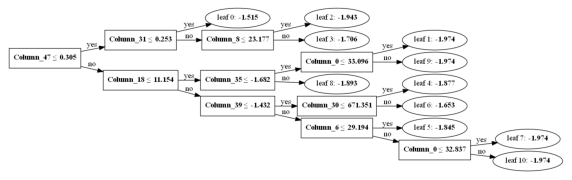

In [173]:
#Let's train a GBDT
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from lightgbm import plot_tree

lgbm=LGBMClassifier(objective='multiclass',max_depth=10**30,num_leaves=30)
lgbm.fit(train_data[:300,:],train_labels[:300])
y_hat=lgbm.predict(train_data[300:,:])
print(accuracy_score(y_hat,train_labels[300:])) #???
print(confusion_matrix(train_labels[300:], y_hat))
plot_tree(lgbm,figsize=(10,7))

Now that the model has been trained, it is necessary to get the data for devkalaka

## Identification and generation of the predictions file

Now that we  already have trained models, let's predict/identify language in new audio data and test our model!!! 

But first, we need to obtain the development partition and do the feature extraction more or less as previously (using the Kalaka class).

**IMPORTANT WARNING** Make sure to use the exact same feature extraction process as the one used for the train set. Otherwise, your model will be in disagreement with your evaluation data, and very likely, will not work at all.


In [236]:
# Download and feature extract
transform_id = 'opensmile'

# Notice that the chunking is mostly useless both in training and prediction with GMMs: each frame is a sample for which we obtain the probs
devkalaka = Kalaka(CWD,'dev', 
                 transform_id=transform_id, 
                 audio_transform=transform[transform_id]['audio_transform'], 
                 chunk_transform=transform[transform_id]['chunk_transform'],
                 chunk_size=transform[transform_id]['chunk_size'], 
                 chunk_hop=transform[transform_id]['chunk_hop']
                )

100%|██████████| 917/917 [1:52:27<00:00,  7.36s/it]      


Now, we can iterate the data and use the models for scoring:

In [237]:
start = time.time()
dev_data = {}

for data, label, basename in devkalaka:
        if basename not in dev_data:
                dev_data[basename] = {'data':[], 'label':label}
        dev_data[basename]['data'].append(data)

## We concatenate all the frames belonging to the same filename
for basename in dev_data:
        dev_data[basename]['data'] = np.concatenate(dev_data[basename]['data'])

print(f'Finished reading all data in {time.time() - start}')

Finished reading all data in 0.2989621162414551


In [238]:
start = time.time()

results_dev = {}
results_dev['ref'] =  np.empty(len(dev_data),dtype=np.int32)
results_dev['hyp'] =  np.empty(len(dev_data),dtype=np.int32)
results_dev['llhs'] = np.empty((len(dev_data), len(LANGUAGES)), dtype=np.float64)
results_dev['fileids'] = list()

for i, fileid in tqdm(enumerate(sorted(dev_data)), total=len(dev_data)):
    data = dev_data[fileid]['data']  # the features
    
    results_dev['fileids'].append(fileid)     #fileid

    # obtain the log-likelihood score for each model and store
    results_dev['llhs'][i,:] = np.array([models[lang].score(data) for lang in LANGUAGES])

    # store the reference. Notice that I only have this for the dev set, not for the eval
    results_dev['ref'][i] = (dev_data[fileid]['label']) #reference

    # Obtain the maximum likelihood languge estimation
    ix = np.argmax(results_dev['llhs'][i,:])
    results_dev['hyp'][i] = LANG2ID[LANGUAGES[ix]]
    
    
print(f'Finished predicting all data in {time.time() - start}')


  0%|          | 0/917 [00:00<?, ?it/s]


NameError: name 'models' is not defined

In [266]:
start = time.time()

results_dev = {}
results_dev['ref'] =  np.empty(len(dev_data),dtype=np.int32)
results_dev['hyp'] =  np.empty(len(dev_data),dtype=np.int32)
results_dev['estimated_prob'] =  np.empty((len(dev_data), len(LANGUAGES)), dtype=np.float64)
results_dev['fileids'] = list()

for i, fileid in tqdm(enumerate(sorted(dev_data)), total=len(dev_data)):
    data = dev_data[fileid]['data']  # the features
    
    results_dev['fileids'].append(fileid)     #fileid

    # obtain the log-likelihood score for each model and store
    results_dev['estimated_prob'][i,:] = np.array([lgbm.predict_proba(data.reshape(1,-1))[0,i] for i in range(len(LANGUAGES))])

    # store the reference. Notice that I only have this for the dev set, not for the eval
    results_dev['ref'][i] = (dev_data[fileid]['label']) #reference

    # Obtain the maximum likelihood languge estimation
    ix = lgbm.predict(data.reshape(1,-1))
    results_dev['hyp'][i] = ix
    
    
print(f'Finished predicting all data in {time.time() - start}')


100%|██████████| 917/917 [00:02<00:00, 306.21it/s]

Finished predicting all data in 2.9981255531311035



## Evaluation
After running the previous cells, we obtain two arrays with the reference and hypothesis labels, respectively (we can also reload them in case we need them). We can use these to obtain different evaluation metrics and inspect the performance (and potential problems) of our system. Of course, you will only be able to do this evaluation with the development set, since you don't have access to the eval labels.

You can for instance obtain a classification report summary:

In [263]:
ref, hyp = results_dev['ref'], results_dev['hyp']
print(classification_report(ref, hyp, target_names=LANGUAGES))

              precision    recall  f1-score   support

      Basque       0.23      0.04      0.07       154
     Catalan       0.17      0.05      0.08       149
     English       0.16      0.75      0.27       150
    Galician       0.20      0.03      0.06       151
  Portuguese       0.07      0.04      0.05       160
     Spanish       0.12      0.03      0.05       153

    accuracy                           0.16       917
   macro avg       0.16      0.16      0.10       917
weighted avg       0.16      0.16      0.09       917



Overall accuracy (this will be the **main metric for system ranking**):

In [264]:
accuracy_score(ref, hyp)

0.1559432933478735

Or a confusion matrix: 

In [ ]:
confusion_matrix(ref, hyp)

and visualize it:

In [ ]:
conf_matrix = confusion_matrix(ref, hyp)

fig, ax = plt.subplots(figsize=(3.0, 3.0))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center')

plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title(f'Confusion Matrix\n(Accuracy {100*accuracy_score(ref, hyp):.2f})', fontsize=12)
plt.show()

These results are poor. The baseline system is very limited in several aspects (features, time context, generative model, etc.). For instance, the likelihood scores are not normalized. It may happen, that one model  provides slightly higher scores for some reason. The following trick sometimes increases slightly the results:

In [ ]:
llhs_norm = (results_dev['llhs'] - results_dev['llhs'].mean(axis=0))
hyp_norm = np.empty(hyp.shape, like=hyp)
for i in range(len(results_dev['fileids'])):
    ix = np.argmax(llhs_norm[i,:])
    hyp_norm[i] = LANG2ID[LANGUAGES[ix]]


In [ ]:
conf_matrix = confusion_matrix(ref, hyp_norm)

fig, ax = plt.subplots(figsize=(3.0, 3.0))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center')

plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title(f'Confusion Matrix\n(Accuracy {100*accuracy_score(ref, hyp_norm):.2f})', fontsize=12)
plt.show()

This "trick" is probematic. Can you discuss why? Can you think of an altenative way of doing the same kind of normalization?

## Running the prediction on the evl partition

Once you are happy with your system and the results obtained in the development set, you are ready to generate the predictions on the `'evl'` partition. To do that, you have to follow the same process as for the development partition, but of course, this time you will not be able to obtain performance results because you don't have labels for this partition. 

We start by instantiating the `Kalaka` class for the `'evl'` partition:


In [ ]:
transform_id = 'mfcc_sdc_vad_chunk_300_300'

evlkalaka = Kalaka(CWD,'evl', 
                 transform_id=transform_id, 
                 audio_transform=transform[transform_id]['audio_transform'], 
                 chunk_transform=transform[transform_id]['chunk_transform'],
                 chunk_size=transform[transform_id]['chunk_size'], 
                 chunk_hop=transform[transform_id]['chunk_hop']
                )


Then, we load the evaluation data:

In [ ]:
start = time.time()
evl_data = {}

for data, label, basename in evlkalaka:
        if basename not in evl_data:
                evl_data[basename] = {'data':[], 'label':label}
        evl_data[basename]['data'].append(data)

for basename in evl_data:
        evl_data[basename]['data'] = np.concatenate(evl_data[basename]['data'])

print(f'Finished reading all data in {time.time() - start}')

And apply the model(s) to the new `'evl'` data:

In [ ]:
start = time.time()

results_evl = {}
results_evl['ref'] =  None
results_evl['hyp'] =  np.empty(len(evl_data),dtype=np.int32)
results_evl['llhs'] = np.empty((len(evl_data), len(LANGUAGES)), dtype=np.float64)
results_evl['fileids'] = list()


# Obtain LLH matrix
for i, fileid in tqdm(enumerate(sorted(evl_data)), total=len(evl_data)):

    data = evl_data[fileid]['data']  # the features
    results_evl['fileids'].append(fileid)     #fileid

    # obtain the log-likelihood score for each model and store
    results_evl['llhs'][i,:] = np.array([models[lang].score(data) for lang in LANGUAGES])

    # Obtain the maximum likelihood languge estimation
    ix = np.argmax(results_evl['llhs'][i,:])
    results_evl['hyp'][i] = LANG2ID[LANGUAGES[ix]]    

print(f'Finished predicting all data in {time.time() - start}')

## Create the predictions file

The predictions file used for submission and scoring is a CSV file containing the predictions of both the `dev` and `evl` partitions.
The file has two fields: fileId and Lang. The fileId is the unique audio file identifier and the Lang field is the language prediction (numeric from 1 to 6). The predictions file name must be as follows:

`T<X>_G<YY>_<SYSTEMID>.csv` 

where `<X>` can be 1 or 2 depending on being a system for track 1 or track 2 evaluation; `<YY>` is the students' group number (use 2 digits) and `<SYSTEMID>` is a identifying string for that submission/system.

In [ ]:
group, system = '00', 'baseline_train100'
with open(f'{os.getcwd()}/T1_G{group}_{system}.csv', 'w') as file:
    csv_writer = csv.writer(file) # CSV writer
    csv_writer.writerow(('fileId', 'Lang')) # Header of the CSV

    # Save dev results
    for i in range(len(results_dev['fileids'])):
        csv_writer.writerow((results_dev['fileids'][i], results_dev['hyp'][i]))
    # Save evl results
    for i in range(len(results_evl['fileids'])):
        csv_writer.writerow((results_evl['fileids'][i], results_evl['hyp'][i]))

## Submit your prediction
You can submit your prediction in the following Kaggle competition: https://www.kaggle.com/competitions/speech-processing-lab-2/

## What should/can you do next?
**Everything!!** Try to extend and improve the feature extraction. Try to play with the parameters. Try completely different feature extraction modules (look for openSMILE, torchaudio,). Try to increase the model complexity. Try different modeling approaches. Try to understand the impact of the different modifications. Once you are happy with your system, try to train on the full set and check the impact of adding data to your system.


# PART 2 - Using pre-trained embeddings (Track 2)

There exist plenty of resources and pre-trained models that can be extremely useful for our task. For instance, x-vectors are currently the state of the art approach to obtain speech embeddings that characterize very efficiently speaker or language, among others. Particularly, the following x-vector model is available and it has been trained using a large corpus of 107 languages for language identification: https://huggingface.co/speechbrain/lang-id-voxlingua107-ecapa

You can obtain it from the `speechbrain` module, that you need to install now if you are using Google Colab:



In [ ]:
# If you are using Google Colab, you'll have to install the speechbrain module
raise CheckThisCell ## <---- Remove this after completing/checking this cell
!pip install speechbrain

The following code cell imports such model and shows how to obtain an embedding vector:

In [ ]:
import torchaudio
import speechbrain

from speechbrain.pretrained import EncoderClassifier
from torch.nn.utils.rnn import pad_sequence

language_id = EncoderClassifier.from_hparams(source="speechbrain/lang-id-voxlingua107-ecapa", savedir="tmp")

signal = language_id.load_audio(f'{CWD}/train100/audio/0a5c0729.wav')
emb =  language_id.encode_batch(signal)

In fact, the model is trained for language identification of 107 languages and we could use it directly for identification:

In [ ]:
prediction =  language_id.classify_batch(signal)

Invest some time to inspect the model and the outputs. Notice that the six target languages are included among the 107. The output indices are: 

```python
XVEC_LANG_INDEX = (24,13,20,29,75,22) 
```

corresponding respectively to the following languages:

```python 
LANGUAGES = ('Basque',  'Catalan',  'English',  'Galician',  'Portuguese',  'Spanish')
```

Knowing this, it should be easy to obtain the predicted class among the six possible candidates:

In [ ]:
XVEC_LANG_INDEX = (24,13,20,29,75,22) 

# Obtain the predicted class out of the 6 target ones
raise CheckThisCell ## <---- Remove this after completeing/checking this cell

## Using the x-vector up-stream model for language ID

Let's try first something simple: use the the pre-trained model for idenfication. In this simple test, you don't need to train anyhing simply classify the dev and test sets. To do so, first configure the right transformation for the Kalaka class (one that simply loads the audio without any chunking):

In [ ]:
# Confifure the tranformation
raise CheckThisCell ## <---- Remove this after completeing/checking this cell

transform = { 
                'raw_xvec' :
                {
                    'audio_transform': None, ## <--- You need to modify this here
                    'chunk_transform': None,
                    'chunk_size': 0,
                    'chunk_hop':0   
                }
            }

# Download and feature extract
transform_id = 'raw_xvec'


devkalaka = Kalaka(CWD, 'dev', 
                 transform_id=transform_id, 
                 audio_transform=transform[transform_id]['audio_transform'], 
                 chunk_transform=transform[transform_id]['chunk_transform'],
                 chunk_size=transform[transform_id]['chunk_size'], 
                 chunk_hop=transform[transform_id]['chunk_hop']
                )

Now you have all the elements to predict langauge using the langID pre-trained model.
In case you have access to a GPU, it may be good using a Pytorch Dataloader to batch the dev samples:

In [ ]:
import torch
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

Since the audios are of different size, we need to pass an auxiliary function to the dataloader that handles this (by adding 0s). This can be done as follows:

In [ ]:
def collate_batch(batch): 
    label_list, audio_list, basename_list, audiolen_list = [], [], [], []

    for (_audio,_label, _basename) in batch:
        label_list.append(_label)
        audio_list.append(_audio)
        basename_list.append(_basename)
        audiolen_list.append(_audio.shape[0])

    label_list = torch.tensor(label_list, dtype=torch.int64)
    audio_list = pad_sequence(audio_list, batch_first=True, padding_value=0)
    max_len = max(audiolen_list)
    audiolen_list = torch.tensor([l/max_len for l in audiolen_list])

    return audio_list.to(device),label_list.to(device), basename_list, audiolen_list.to(device)

batch_size = 10
dataloader = torch.utils.data.DataLoader(
        dataset=devkalaka,
        batch_size=batch_size,
        collate_fn=collate_batch,
        shuffle=False  # <-- We want to keep the original order of the dev set
)


Complete the following piece of code to store properly the hypothesis and the reference:

In [ ]:
import time
from tqdm import tqdm
start = time.time()

results_dev = {}
results_dev['ref'] =  []
results_dev['hyp'] =  []
results_dev['fileids'] = [] 

for i, batch in tqdm(enumerate(dataloader), total=1+len(devkalaka)//batch_size):
    data, label, basename, audiolen = batch
    predictions = language_id.classify_batch(data, wav_lens=audiolen)
    
    # Complete the code to store the hypothesis (careful if you use argmax, you will ned to add 1 to the predicted class),
    # the reference and the fileids. In the call to the prediction method, you should pass the audio length information, so that 
    # the padded 0s can be ignored
    raise CheckThisCell ## <---- Remove this after completeing/checking this cell
    
print(f'Finished preocessing all data in {time.time() - start}')

And now let's see how well this model behaves on our dev partition:

In [ ]:
ref, hyp = results_dev['ref'], results_dev['hyp']

conf_matrix = confusion_matrix(ref, hyp)

fig, ax = plt.subplots(figsize=(3.0, 3.0))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center')

plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title(f'Confusion Matrix\n(Accuracy {100*accuracy_score(ref, hyp):.2f})', fontsize=12)
plt.show()

That was pretty impressive, right!?! And  easier than Part I of this lab! 

Well, here comes some bad news: you can not use this langid classifier in the challenge. However, you can use the pre-trained x-vector embeddings as a feature extractor to train your language classification system (may be a simple K-means on top of the x-vectors work well). You can also try to change the classification head of the x-vector model and fine-tune with the challenge data. You have plenty of options, but remember, any system that use these pre-trained embeddings (or any similar ones) are only valid for the Track 2 of the Challenge and the prediction file should be  namedlike this: `T2_G<YY>_<SYSTEMID>.csv` 



# What should you deliver at the end of this lab assignment?
You should deliver the following three elements:
- You must submit at least one prediction file to the Kaggle competition in the format previously described: https://www.kaggle.com/competitions/speech-processing-lab-2/
- You must submit (via Fênix) the modified notebook (or code) of your proposed systems(s).
- You must submit a report (via Fênix) of maximum 2 pages describing your system, approaches (may be unsuccesful), lessons learnt, results on the dev partition, etc. You can use the following Overleaf template for the report: https://www.overleaf.com/latex/templates/interspeech-2023-paper-kit/kzcdqdmkqvbr

# Contacts and support
You can contact the professors during the classes or the office hours.

Particularly, for this second laboratory assignment, you should contact Prof. Alberto Abad: alberto.abad@tecnico.ulisboa.pt



